In [1]:
import csv
import xlrd
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from bayes_opt import BayesianOptimization
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

Using TensorFlow backend.


In [2]:
from sklearn.metrics import roc_auc_score

def precision(predict_ensemble,y_test):
    predict_ensemble[predict_ensemble >= 1] = 1
    predict_ensemble[predict_ensemble <= -1] = -1
    
    test_length = len(y_test)
    score = len(y_test[predict_ensemble == y_test]) / test_length
    classified1 = len(predict_ensemble[predict_ensemble == -1])
    ob1_clf1 = 0
    
    if classified1==0:
        classified1=1
          
    for i in range(len(predict_ensemble)):
        if predict_ensemble[i] == -1 and y_test[i] == -1:
            ob1_clf1 += 1
    type1 = ob1_clf1 / classified1
    
    classified2 = len(predict_ensemble[predict_ensemble == 1])
    
    if classified2==0:
        classified2 =1
    ob2_clf2 = 0
    for i in range(len(predict_ensemble)):
        if predict_ensemble[i] == 1 and y_test[i] == 1:
            ob2_clf2 += 1
            
    type2 = ob2_clf2 / classified2
    
    bad_preci = len(y_test[y_test == -1])
    if bad_preci==0:
        bad_preci = 1
    bad_preci_clf1 = 0
         
    for i in range(len(y_test)):
        if predict_ensemble[i] == -1 and y_test[i] == -1:
            bad_preci_clf1 += 1
    bad = bad_preci_clf1 / bad_preci
    
    good_preci = len(y_test[y_test == 1])
    good_preci_clf2 = 0
    for i in range(len(y_test)):
        if predict_ensemble[i] == 1 and y_test[i] == 1:
            good_preci_clf2 += 1
    good = good_preci_clf2 / good_preci
    
    auc = roc_auc_score(y_test, predict_ensemble)
    print('&',round(bad,3),'&',round(good,3),\
          '&', round(type1,3), '&', round(type2,3), '&', round(score,3),'&', round(auc,3))
    print('AUC:', auc)
    return (round(bad,3),round(good,3),round(type1,3),round(type2,3),round(score,3)), auc


In [3]:
data = pd.read_csv('./ovd_cleared.csv')

data['Date of disbursment '] = pd.to_datetime(data['Date of disbursment '],format='%Y-%m-%d')
data['Loan classification'][data['Loan classification']==1] = -1
data['Loan classification'][data['Loan classification']==0] = 1
startdate = datetime.datetime.strptime('2014-05-20', '%Y-%m-%d')
data['issueDateDT'] = data['Date of disbursment '].apply(lambda x: x-startdate).dt.days
data.drop(columns = ['Date of disbursment '], inplace=True)

data

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Age  Marital Status  Education Type  \
0       45               2               5   
1       54               2               5   
2       51               2               5   
3       48               2               5   
4       52               2               5   
...    ...             ...             ...   
11363   38               2               5   
11364   47               2               5   
11365   53               2               4   
11366   58               2               4   
11367   43               2               5   

       Number of years at the current address  Employment Type   \
0                                       17.41                 6   
1                                       17.58                 9   
2                                       31.25                 7   
3                                       12.33                 7   
4                                       10.91                 9   
...                                       ...               ...   
11363                                   14.16                 6   
11364                                   46.50                 6   
11365                                   19.50                 6   
11366                                   57.91                 6   
11367                                   19.08                 6   

       Current years at job  Credit Registry Information  Monthly Income   \
0                      1.58                            2          68000.0   
1                     21.08                            4         500000.0   
2                     13.25                            2          95000.0   
3                      7.00                            2          90000.0   
4                     12.91                            2         300000.0   
...                     ...                          ...              ...   
11363                  7.08                            2         100000.0   
11364                  9.50                            2         105000.0   
11365                 19.50                            2          68800.0   
11366                 13.50                            2          65700.0   
11367                  2.16                            1          65000.0   

       Reference  Sex  ...  Monthly Income log  \
0              2    0  ...           11.127278   
1              1    1  ...           13.122365   
2              1    1  ...           11.461643   
3              2    1  ...           11.407576   
4              2    1  ...           12.611541   
...          ...  ...  ...                 ...   
11363          2    0  ...           11.512935   
11364          3    1  ...           11.561725   
11365          3    0  ...           11.138974   
11366          3    1  ...           11.092869   
11367          1    0  ...           11.082158   

       Monthly Installment of the loan log  CREDIT_INCOME_PERCENT  \
0                                 8.517393               2.647059   
1                                 8.294300               0.600000   
2                                 7.682943               2.284211   
3                                 7.601402               0.777778   
4                                 5.278115               6.064500   
...                                    ...                    ...   
11363                             7.550135               1.900000   
11364                             7.824446               2.380952   
11365                             6.908755               1.453488   
11366                             7.313887               2.283105   
11367                             7.496097               1.538462   

       INSTALL_CREDIT_PERCENT  JOB_AGE_PERCENT  ADDRESS_AGE_PERCENT  \
0                    0.027778         0.035111             0.386889   
1                    0.013333         0.390370             0.325556   
2                    0.010000         0.259804             0.612745   
3         

In [7]:
y = data['Loan classification']
X = data.drop(columns = ['Loan classification'])
y = np.array(y)
X = np.array(X)
kcv = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for index_train, index_test in kcv.split(X, y):
    traindata_X = X[index_train]
    traindata_y = y[index_train]
    test_X = X[index_test]
    test_y = y[index_test]

In [8]:
all_aucs = []
aucs = []
f1s = []
test_aucs = []
clf = RandomForestClassifier(ccp_alpha=0.001,class_weight={-1: 25, 1: 1}, max_leaf_nodes=60,
n_estimators = 90,criterion ='entropy',min_samples_leaf=30,min_samples_split=50,
max_depth=11,oob_score=True, random_state=10)
sf = StratifiedShuffleSplit(n_splits=5)

for train, valid in sf.split(traindata_X, traindata_y):
    train_y = traindata_y[train]
    train_X = traindata_X[train]
    valid_y = traindata_y[valid]
    valid_X = traindata_X[valid]
    
    clf.fit(train_X, train_y)
    y_pred = clf.predict(valid_X)
    y_prob = clf.predict_proba(valid_X)[:,1]
    print('validation set')
    precision(y_pred, valid_y)

    auc = roc_auc_score(valid_y, y_pred)
    aucs.append(auc)
    
    f1 = f1_score(valid_y, y_pred, average='weighted')
    f1s.append(f1)
    
    predict_y = clf.predict(test_X)
    print('test set')
    precision(predict_y, test_y)
    test_aucs.append(roc_auc_score(test_y, predict_y))


validation set
& 0.738 & 0.727 & 0.155 & 0.976 & 0.728 & 0.733
AUC: 0.7326301435790488
test set
& 0.792 & 0.728 & 0.164 & 0.981 & 0.732 & 0.76
AUC: 0.7596830985915493
validation set
& 0.738 & 0.721 & 0.152 & 0.976 & 0.722 & 0.73
AUC: 0.7295018849763375
test set
& 0.736 & 0.711 & 0.147 & 0.976 & 0.712 & 0.723
AUC: 0.7234546165884195
validation set
& 0.738 & 0.727 & 0.155 & 0.976 & 0.728 & 0.733
AUC: 0.7326301435790488
test set
& 0.694 & 0.726 & 0.146 & 0.972 & 0.724 & 0.71
AUC: 0.7101330203442879
validation set
& 0.631 & 0.718 & 0.132 & 0.966 & 0.713 & 0.675
AUC: 0.6746129782626132
test set
& 0.736 & 0.718 & 0.15 & 0.976 & 0.719 & 0.727
AUC: 0.7272104851330204
validation set
& 0.754 & 0.731 & 0.16 & 0.978 & 0.732 & 0.742
AUC: 0.7424079570064972
test set
& 0.736 & 0.728 & 0.155 & 0.976 & 0.728 & 0.732
AUC: 0.7319053208137716


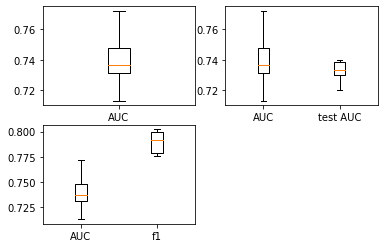

In [29]:
plt.subplot(2,2,1)
plt.boxplot(aucs, labels=['AUC'])

plt.subplot(2,2,2)
plt.boxplot([aucs, test_aucs], labels=['AUC','test AUC'])

plt.subplot(2,2,3)
plt.boxplot([aucs, f1s], labels=['AUC','f1'])
plt.show()